## Clean Semi-supervised `MobileNetV3` model

In [1]:
import os
import torch
import argparse
import copy
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from mobilenetv3 import MobileNetV3
from tqdm.auto import tqdm
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler, Subset
from new_datasets import TrafficSignDataset
from sklearn.model_selection import train_test_split
# from utils import save_model, save_plots
# from utils import save_plots
# from ResultWriter import ResultWriter 
# from statistics import accuracy, AverageMeter, ProgressMeter

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [2]:
# For mobilenetv3
train_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.3403, 0.3121, 0.3214),
                        (0.2724, 0.2608, 0.2669))
])
test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.3403, 0.3121, 0.3214),
                        (0.2724, 0.2608, 0.2669))
])

### Split train dataset into `labeled` and `unlabeled` dataset

In [3]:
# Load the training and validation datasets.
train_dir = '../inputs/cifar10/train'
test_dir = '../inputs/cifar10/test'

train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform) 

test_size =  len(test_dataset)
classes = train_dataset.classes
targets = train_dataset.targets # classes 

# split train data into lbl, unlbl dataset with the ratio of 1:9
label_idx, unlabelled_idx = train_test_split(np.arange(len(targets)), 
                                        test_size = 0.9, 
                                        shuffle = True, 
                                        stratify = targets)

#create a dict of labelled data (idx: label)
lb, gt_labels = {}, []
for img_idx in label_idx:
    lb[img_idx] = train_dataset.targets[img_idx]

for idx in unlabelled_idx:
    gt_labels.append(train_dataset.targets[idx])

label_dataset = Subset(train_dataset, label_idx)
unlabelled_dataset = Subset(train_dataset, unlabelled_idx)

label_size = len(label_dataset)
unlabelled_size = len(unlabelled_dataset)

labelled_loader = DataLoader(
    label_dataset, batch_size=64,
    num_workers=4, pin_memory=True,
)
ulb_loader = DataLoader(
    unlabelled_dataset, batch_size=16,
    num_workers=4, pin_memory=True,
)
test_loader = DataLoader(
    test_dataset, batch_size=64,
    num_workers=4, pin_memory=True,
)

print("Using 0.1 train data to train the model")
print("[INFO]: Label Dataset Size: ", label_size)
print("[INFO]: Unlabelled Dataset Size: ", unlabelled_size)
print("[INFO]: Test Size: ", test_size)
print(f"[INFO]: Class names: {classes}\n")

Using 0.1 train data to train the model
[INFO]: Label Dataset Size:  5000
[INFO]: Unlabelled Dataset Size:  45000
[INFO]: Test Size:  10000
[INFO]: Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



In [4]:
# save ulb in a df
ulb_index = np.array(unlabelled_idx)
gt_label = np.array(gt_labels)
df = pd.DataFrame({'img_idx':ulb_index, 'gt_label':gt_label}, columns=['img_idx', 'gt_label'])

In [5]:
print(df)

       img_idx  gt_label
0        36047         7
1         6623         1
2        12162         2
3         9673         1
4        21634         4
...        ...       ...
44995    45202         9
44996    37634         7
44997    28392         5
44998    30101         6
44999    18236         3

[45000 rows x 2 columns]


In [6]:
train_class_count = []
for class_idx in range(10):
    count = 0
    for x in lb.values():
        if x == class_idx:
            count += 1
    train_class_count.append(count)

print("Image count for each class: ", train_class_count)
# print(ulb.values()) # the sequence is preserved

Image count for each class:  [500, 500, 500, 500, 500, 500, 500, 500, 500, 500]


### Create empty `MobileNetV3` model

In [7]:
# use GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# get model
model = MobileNetV3(mode='small', classes_num=10, input_size=32)

if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)
    
model.to(device)

MobileNetV3(
  (featureList): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): H_swish()
    )
    (1): Bottleneck(
      (conv1): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SEModule(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (fc): Sequential(
            (0): Linear(in_features=16, out_features=4, bias=False)
            (1): ReLU(inplace=True)
            (2): Linear(in_features=4, out_features=16, bias=False)
            (3): H_sigmoid()
          )
        )
        (3): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): Sequ

### Model Hyperparameters and Define Iterative Training func.

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Learning Rate Scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.1)

save_path = '../outputs/trained_model/ssl_clean'
learning_rate = []
training_loss = []
training_accuracy = []

def lbl_train(current_epoch, num_epoch, model, loader):
    current_loss = 0.0
    current_corrects = 0
    losses = []

    scheduler.step(current_epoch)
    
    model.train()

    loop = tqdm(enumerate(loader), total=len(loader)) # create a progress bar
    for batch_idx, (data, targets) in loop:
        data = data.to(device=device)
        targets = targets.to(device=device)
        scores = model(data)
        
        loss = criterion(scores, targets)
        optimizer.zero_grad()
        losses.append(loss)
        
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(scores, 1)
        current_loss += loss.item() * data.size(0)
        current_corrects += (preds == targets).sum().item()
        loop.set_description(f"Epoch {current_epoch+1}/{num_epoch} process: {int((batch_idx / len(loader)) * 100)}")
        loop.set_postfix(loss=loss.data.item())
    
    epoch_accuracy = current_corrects / label_size * 100
    epoch_losses =  current_loss / label_size
    training_accuracy.append(epoch_accuracy)
    training_loss.append(epoch_losses)
    
    # save model at last epoch
    if current_epoch == 9:
        torch.save({ 
                    'model_state_dict': model.state_dict(), 
                    'optimizer_state_dict': optimizer.state_dict(), 
                    }, os.path.join(save_path,'checkpoint_warmup_train'+'.pth'))

warmup_acc = []
warmup_loss = []

def get_test_acc(model):
    model.eval()
    current_loss = 0
    epoch_loss = 0
    correct = 0
    with torch.no_grad():
        for data, targets in test_loader:
            data = data.to(device)
            targets = targets.to(device)
            scores = model(data)
            _, predictions = torch.max(scores, 1)
            correct += (predictions == targets).sum().item()
            loss = criterion(scores, targets)
            current_loss += loss.item() * data.size(0)
            
    epoch_loss = current_loss / test_size
    test_epoch_acc = correct / test_size * 100
    warmup_loss.append(epoch_loss)
    warmup_acc.append(test_epoch_acc)


### Generate `Pseudo-label` for all Unlabeled Data

In [9]:
# create psuedo-label for ulb data
def label(model):
    psuedolb = []
    model.eval()
    with torch.no_grad():
        for data, targets in ulb_loader:
            data = data.to(device)
            # targets = targets.to(device)
            outputs = model(data)
            _, predictions = torch.max(outputs, 1)
            predictions=predictions.cpu().numpy() # get np values of a tensor
            psuedolb.extend(predictions)
    return psuedolb

In [10]:
#train model using labelled data with 10 epochs
lbl_train_eph = 10
for x in range(lbl_train_eph):
    lbl_train(current_epoch=x, num_epoch=lbl_train_eph, model=model, loader=labelled_loader)
    get_test_acc(model=model)

c:\Users\65913\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
c:\Users\65913\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https:/

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

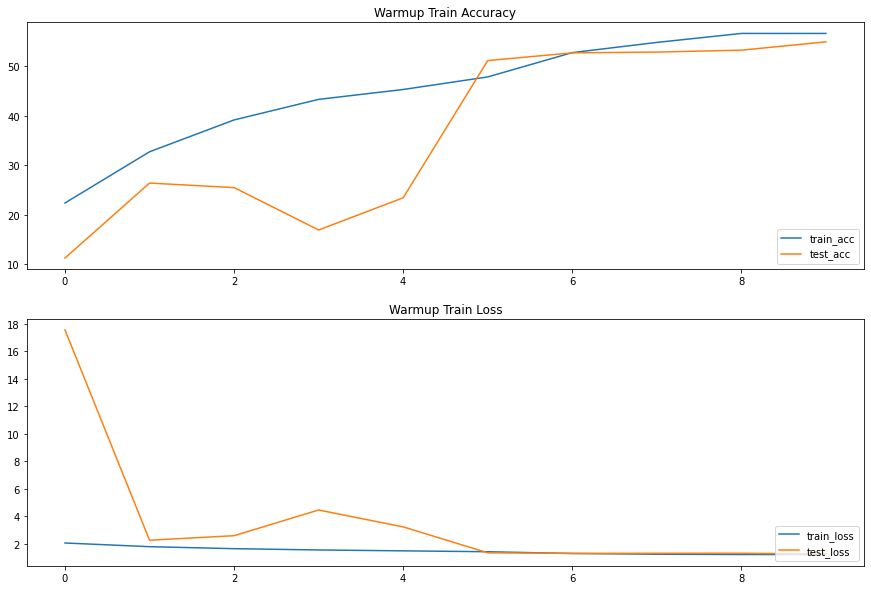

In [11]:
fig, axs = plt.subplots(2, figsize=(15,10))
axs[0].set_title('Warmup Train Accuracy')
axs[0].plot(training_accuracy,label='train_acc')
axs[0].plot(warmup_acc,label='test_acc')
axs[0].legend(loc='lower right')

axs[1].set_title('Warmup Train Loss')
axs[1].plot(training_loss,label='train_loss')
axs[1].plot(warmup_loss,label='test_loss')
axs[1].legend(loc='lower right')

In [12]:
#create psusedo-lbl using trained model
chkpoint_dir = '../outputs/trained_model/ssl_clean/checkpoint_warmup_train.pth'
checkpoint = torch.load(chkpoint_dir)

model.load_state_dict(checkpoint["model_state_dict"])

psuedolb = label(model)

print("Outputs count: ",len(psuedolb))
df['Psuedo-lb'] = psuedolb

for idx, img_idx in enumerate(unlabelled_idx):
    train_dataset.targets[img_idx] = psuedolb[idx]

print("Created psuedo-label for ulb data")

Outputs count:  45000
Created psuedo-label for ulb data


In [13]:
print(df)

       img_idx  gt_label  Psuedo-lb
0        36047         7          9
1         6623         1          1
2        12162         2          2
3         9673         1          1
4        21634         4          3
...        ...       ...        ...
44995    45202         9          5
44996    37634         7          7
44997    28392         5          3
44998    30101         6          6
44999    18236         3          3

[45000 rows x 3 columns]


In [14]:
num_epochs = 200
epoch_ratio = 0.08
ulb_train_acc, ulb_train_loss = [], []
test_acc, test_loss = [], []

# reset learning rate
optimizer = optim.SGD(model.parameters(), lr=0.1)
scheduler = lr_scheduler.StepLR(optimizer, step_size = 40, gamma = 0.1)

def shuffle_ulb():
    ulb_batch_idx = []

    # select from ulb_idx
    ulb_batch_idx = random.choices(unlabelled_idx, k=round(unlabelled_size * epoch_ratio))
    
    # join the selected ulb with lbl
    for lbl_idx in label_idx:
        ulb_batch_idx.append(lbl_idx)

    epoch_dataset = Subset(train_dataset, ulb_batch_idx)

    epoch_loader = DataLoader(
        epoch_dataset, batch_size=16,
        num_workers=4, pin_memory=True,
    )

    return epoch_loader, ulb_batch_idx


def generate_psuedolbl(model, epoch):
    psuedolb = []
    # predict new psuedo-lbl for ulb dataset
    model.eval()
    with torch.no_grad():
        for data, targets in ulb_loader:
            data = data.to(device)
            # targets = targets.to(device)
            outputs = model(data)
            _, predictions = torch.max(outputs, 1)
            predictions=predictions.cpu().numpy() # get np values of a tensor
            psuedolb.extend(predictions)
    
    # update label of all ulb data
    # df['Psuedo-lb'] = psuedolb    
    for idx, img_idx in enumerate(unlabelled_idx):
        train_dataset.targets[img_idx] = psuedolb[idx]

    # print("Created new psuedo-lbl for ulb dataset")

def get_test_acc(model):
    model.eval()
    current_loss = 0
    epoch_loss = 0
    correct = 0
    with torch.no_grad():
        for data, targets in test_loader:
            data = data.to(device)
            targets = targets.to(device)
            scores = model(data)
            _, predictions = torch.max(scores, 1)
            correct += (predictions == targets).sum().item()
            loss = criterion(scores, targets)
            current_loss += loss.item() * data.size(0)
            
    epoch_loss = current_loss / test_size
    test_epoch_acc = correct / test_size * 100
    test_loss.append(epoch_loss)
    test_acc.append(test_epoch_acc)

    return test_epoch_acc

def ulb_train(current_epoch, num_epoch, model, loader):
    current_loss = 0.0
    current_corrects = 0
    model.train()

    loop = tqdm(enumerate(loader), total=len(loader)) # create a progress bar
    for batch_idx, (data, targets) in loop:
        data = data.to(device=device)
        targets = targets.to(device=device)
        scores = model(data)
        
        loss = criterion(scores, targets)
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(scores, 1)
        current_loss += loss.item() * data.size(0)
        current_corrects += (preds == targets).sum().item()
        loop.set_description(f"Epoch {current_epoch+1}/{num_epoch} process: {int((batch_idx / len(loader)) * 100)}")
        loop.set_postfix(loss=loss.data.item())
    
    # save model
    # final_acc = current_corrects / unlabelled_size * 100
    # ulb_train_acc.append(final_acc)
    epoch_losses =  current_loss / label_size
    training_loss.append(epoch_losses)

    if (current_epoch+1) % 20 == 0:
        torch.save({ 
            'model_state_dict': model.state_dict(), 
            'optimizer_state_dict': optimizer.state_dict(), 
            }, os.path.join(save_path, 'ulb_train_checkpoint_epoch_' + str(current_epoch+1)+'.pth'))

### `Iterative training`

In [15]:
# ground truth dataset to validate error
gt_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)

#convert into for loop eventually
print("New batch size(including lbl): ", label_size+round(unlabelled_size * epoch_ratio))

############### Start of main ulb training ######################
for current_epochs in range(num_epochs):
    train_correct = 0
    test_correct = 0
    psuedolb = []

    # handle model
    if current_epochs == 0:
        # load model trained with lbl data (warmup)
        model_dir = chkpoint_dir
        checkpoint = torch.load(model_dir)
        model.load_state_dict(checkpoint["model_state_dict"])
    
    # Shuffle ulb_idx for new train
    epoch_loader, ulb_batch_idx = shuffle_ulb()

    # Re-train the model
    ulb_train(current_epoch=current_epochs, num_epoch=num_epochs, model=model, loader=epoch_loader)
    
    # Generate new label (Save to train_dataset)
    generate_psuedolbl(model, current_epochs)
    
    # Get epoch_acc
    for idx in unlabelled_idx:
        # get train acc
        if train_dataset.targets[idx] == gt_dataset.targets[idx]:
            train_correct += 1

    final_acc = train_correct / unlabelled_size * 100
    ulb_train_acc.append(final_acc)
    
    # Get test_acc
    curr_test_acc = get_test_acc(model)

    print("Current Epoch:", current_epochs, " Train Acc:", final_acc, " Test Acc:", curr_test_acc)

New batch size(including lbl):  8600


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 0  Train Acc: 42.11111111111111  Test Acc: 41.19


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 1  Train Acc: 43.43555555555555  Test Acc: 43.91


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 2  Train Acc: 50.02444444444445  Test Acc: 49.51


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 3  Train Acc: 55.888888888888886  Test Acc: 57.19


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 4  Train Acc: 61.144444444444446  Test Acc: 62.29


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 5  Train Acc: 58.8  Test Acc: 60.62


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 6  Train Acc: 65.02222222222223  Test Acc: 65.12


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 7  Train Acc: 62.355555555555554  Test Acc: 63.12


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 8  Train Acc: 66.95333333333333  Test Acc: 67.67999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 9  Train Acc: 68.4  Test Acc: 68.53


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 10  Train Acc: 67.41777777777777  Test Acc: 67.64


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 11  Train Acc: 67.25333333333333  Test Acc: 66.52


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 12  Train Acc: 69.53777777777778  Test Acc: 69.78


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 13  Train Acc: 72.41333333333333  Test Acc: 73.32


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 14  Train Acc: 69.60888888888888  Test Acc: 69.78999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 15  Train Acc: 72.6711111111111  Test Acc: 73.25


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 16  Train Acc: 73.52888888888889  Test Acc: 74.05000000000001


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 17  Train Acc: 70.80888888888889  Test Acc: 71.6


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 18  Train Acc: 72.01111111111112  Test Acc: 72.28


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 19  Train Acc: 73.53777777777778  Test Acc: 73.61999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 20  Train Acc: 74.32444444444445  Test Acc: 74.42999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 21  Train Acc: 76.3711111111111  Test Acc: 76.28


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 22  Train Acc: 74.64666666666666  Test Acc: 74.9


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 23  Train Acc: 76.74  Test Acc: 76.42999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 24  Train Acc: 73.96888888888888  Test Acc: 74.02


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 25  Train Acc: 76.61333333333333  Test Acc: 76.49000000000001


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 26  Train Acc: 76.68444444444444  Test Acc: 76.64


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 27  Train Acc: 77.49777777777777  Test Acc: 77.32


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 28  Train Acc: 73.60222222222222  Test Acc: 73.3


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 29  Train Acc: 78.02666666666667  Test Acc: 77.97


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 30  Train Acc: 76.65333333333334  Test Acc: 76.0


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 31  Train Acc: 78.99555555555555  Test Acc: 78.44


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 32  Train Acc: 78.97999999999999  Test Acc: 78.7


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 33  Train Acc: 78.39111111111112  Test Acc: 78.01


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 34  Train Acc: 77.56444444444445  Test Acc: 77.5


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 35  Train Acc: 78.63777777777777  Test Acc: 78.53


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 36  Train Acc: 80.31111111111112  Test Acc: 79.59


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 37  Train Acc: 80.2511111111111  Test Acc: 79.56


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 38  Train Acc: 79.5488888888889  Test Acc: 79.80000000000001


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 39  Train Acc: 80.50666666666667  Test Acc: 80.06


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 40  Train Acc: 80.43555555555557  Test Acc: 79.83


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 41  Train Acc: 80.71333333333334  Test Acc: 79.95


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 42  Train Acc: 80.66  Test Acc: 79.92


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 43  Train Acc: 81.50444444444445  Test Acc: 80.65


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 44  Train Acc: 81.2311111111111  Test Acc: 80.16


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 45  Train Acc: 81.58888888888889  Test Acc: 81.27


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 46  Train Acc: 81.34444444444443  Test Acc: 81.08999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 47  Train Acc: 81.49777777777778  Test Acc: 80.25999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 48  Train Acc: 82.05777777777777  Test Acc: 81.10000000000001


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 49  Train Acc: 81.88666666666666  Test Acc: 80.87


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 50  Train Acc: 82.59777777777778  Test Acc: 82.08


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 51  Train Acc: 82.09333333333333  Test Acc: 81.73


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 52  Train Acc: 82.63555555555556  Test Acc: 81.43


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 53  Train Acc: 82.60888888888888  Test Acc: 81.97


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 54  Train Acc: 82.92444444444445  Test Acc: 81.93


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 55  Train Acc: 82.14  Test Acc: 81.39


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 56  Train Acc: 83.08666666666666  Test Acc: 82.13000000000001


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 57  Train Acc: 83.63111111111111  Test Acc: 82.72


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 58  Train Acc: 83.51333333333332  Test Acc: 82.6


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 59  Train Acc: 83.85777777777777  Test Acc: 82.64


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 60  Train Acc: 83.83777777777777  Test Acc: 83.0


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 61  Train Acc: 83.39999999999999  Test Acc: 82.39


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 62  Train Acc: 84.0  Test Acc: 83.37


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 63  Train Acc: 84.30222222222223  Test Acc: 82.89999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 64  Train Acc: 84.41333333333333  Test Acc: 83.27


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 65  Train Acc: 84.43333333333334  Test Acc: 83.17


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 66  Train Acc: 83.23333333333333  Test Acc: 81.85


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 67  Train Acc: 84.70666666666666  Test Acc: 83.28


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 68  Train Acc: 84.36444444444444  Test Acc: 83.23


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 69  Train Acc: 84.95777777777778  Test Acc: 83.52000000000001


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 70  Train Acc: 84.90444444444445  Test Acc: 83.37


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 71  Train Acc: 84.02  Test Acc: 82.50999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 72  Train Acc: 84.71333333333332  Test Acc: 83.39


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 73  Train Acc: 84.81555555555556  Test Acc: 83.39999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 74  Train Acc: 85.16444444444444  Test Acc: 83.67


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 75  Train Acc: 85.11777777777777  Test Acc: 83.75


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 76  Train Acc: 85.11555555555556  Test Acc: 83.31


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 77  Train Acc: 85.17555555555556  Test Acc: 83.94


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 78  Train Acc: 85.11111111111111  Test Acc: 83.63000000000001


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 79  Train Acc: 85.50444444444445  Test Acc: 84.09


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 80  Train Acc: 85.75555555555555  Test Acc: 84.05


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 81  Train Acc: 85.78666666666666  Test Acc: 84.16


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 82  Train Acc: 85.97555555555556  Test Acc: 84.35000000000001


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 83  Train Acc: 85.83555555555556  Test Acc: 84.17


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 84  Train Acc: 85.16888888888889  Test Acc: 83.47


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 85  Train Acc: 86.45777777777778  Test Acc: 84.69


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 86  Train Acc: 86.73555555555555  Test Acc: 84.61


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 87  Train Acc: 85.95777777777778  Test Acc: 84.42


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 88  Train Acc: 86.57555555555555  Test Acc: 84.54


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 89  Train Acc: 86.04222222222222  Test Acc: 83.78


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 90  Train Acc: 86.01555555555555  Test Acc: 84.26


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 91  Train Acc: 85.42888888888889  Test Acc: 83.87


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 92  Train Acc: 86.23111111111112  Test Acc: 84.69


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 93  Train Acc: 86.77333333333334  Test Acc: 84.66


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 94  Train Acc: 87.07333333333334  Test Acc: 85.03


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 95  Train Acc: 86.96222222222222  Test Acc: 84.78999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 96  Train Acc: 87.05777777777777  Test Acc: 85.1


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 97  Train Acc: 87.01777777777778  Test Acc: 85.17


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 98  Train Acc: 86.92  Test Acc: 84.64


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 99  Train Acc: 87.21777777777778  Test Acc: 84.89999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 100  Train Acc: 87.19111111111111  Test Acc: 85.0


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 101  Train Acc: 87.46888888888888  Test Acc: 84.94


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 102  Train Acc: 87.36  Test Acc: 84.75


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 103  Train Acc: 87.69555555555556  Test Acc: 85.26


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 104  Train Acc: 87.56888888888888  Test Acc: 85.28


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 105  Train Acc: 87.27777777777777  Test Acc: 84.94


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 106  Train Acc: 87.25111111111111  Test Acc: 84.39


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 107  Train Acc: 87.91333333333333  Test Acc: 85.37


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 108  Train Acc: 87.49333333333334  Test Acc: 85.08


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 109  Train Acc: 87.74222222222222  Test Acc: 85.2


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 110  Train Acc: 87.76444444444445  Test Acc: 85.32


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 111  Train Acc: 87.86444444444444  Test Acc: 85.17


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 112  Train Acc: 88.01777777777777  Test Acc: 85.56


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 113  Train Acc: 88.19555555555556  Test Acc: 85.65


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 114  Train Acc: 87.89555555555556  Test Acc: 85.34


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 115  Train Acc: 88.31777777777778  Test Acc: 85.92


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 116  Train Acc: 87.71555555555555  Test Acc: 85.22


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 117  Train Acc: 87.97777777777777  Test Acc: 85.35000000000001


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 118  Train Acc: 88.62666666666667  Test Acc: 85.82


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 119  Train Acc: 88.6288888888889  Test Acc: 85.99


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 120  Train Acc: 88.45777777777778  Test Acc: 85.92999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 121  Train Acc: 88.41111111111111  Test Acc: 85.82


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 122  Train Acc: 88.63555555555556  Test Acc: 85.98


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 123  Train Acc: 88.59777777777778  Test Acc: 85.91


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 124  Train Acc: 88.42222222222222  Test Acc: 85.88


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 125  Train Acc: 88.72  Test Acc: 86.17


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 126  Train Acc: 88.42444444444445  Test Acc: 85.66


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 127  Train Acc: 88.75555555555556  Test Acc: 85.91


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 128  Train Acc: 88.96222222222222  Test Acc: 86.14


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 129  Train Acc: 88.77555555555556  Test Acc: 85.95


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 130  Train Acc: 88.45333333333333  Test Acc: 85.79


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 131  Train Acc: 88.68  Test Acc: 85.72


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 132  Train Acc: 89.03555555555556  Test Acc: 86.48


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 133  Train Acc: 88.83777777777779  Test Acc: 85.87


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 134  Train Acc: 89.04222222222222  Test Acc: 86.53


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 135  Train Acc: 88.83555555555556  Test Acc: 85.87


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 136  Train Acc: 89.29333333333334  Test Acc: 86.31


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 137  Train Acc: 88.98888888888888  Test Acc: 86.26


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 138  Train Acc: 89.04222222222222  Test Acc: 85.92999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 139  Train Acc: 89.21777777777777  Test Acc: 86.33999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 140  Train Acc: 89.37777777777778  Test Acc: 85.81


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 141  Train Acc: 89.17777777777778  Test Acc: 86.29


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 142  Train Acc: 89.39777777777778  Test Acc: 85.92


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 143  Train Acc: 89.58666666666667  Test Acc: 86.38


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 144  Train Acc: 89.04666666666667  Test Acc: 86.19


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 145  Train Acc: 89.37555555555555  Test Acc: 86.08


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 146  Train Acc: 89.08  Test Acc: 85.84


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 147  Train Acc: 89.4  Test Acc: 86.22


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 148  Train Acc: 89.85333333333332  Test Acc: 86.52


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 149  Train Acc: 89.65111111111112  Test Acc: 86.28


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 150  Train Acc: 89.85555555555555  Test Acc: 86.63


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 151  Train Acc: 89.84222222222222  Test Acc: 86.42


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 152  Train Acc: 90.07111111111111  Test Acc: 86.31


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 153  Train Acc: 89.98222222222222  Test Acc: 86.53


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 154  Train Acc: 89.97111111111111  Test Acc: 86.49


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 155  Train Acc: 90.05777777777779  Test Acc: 86.33


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 156  Train Acc: 90.01777777777778  Test Acc: 86.27


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 157  Train Acc: 89.87777777777778  Test Acc: 86.31


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 158  Train Acc: 90.05555555555556  Test Acc: 86.53999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 159  Train Acc: 90.01333333333334  Test Acc: 86.36


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 160  Train Acc: 90.19555555555556  Test Acc: 86.74


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 161  Train Acc: 89.77111111111111  Test Acc: 86.37


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 162  Train Acc: 90.12  Test Acc: 86.48


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 163  Train Acc: 90.13333333333333  Test Acc: 86.50999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 164  Train Acc: 90.28  Test Acc: 86.33999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 165  Train Acc: 90.22666666666666  Test Acc: 86.41


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 166  Train Acc: 90.48  Test Acc: 86.59


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 167  Train Acc: 90.48666666666666  Test Acc: 87.16000000000001


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 168  Train Acc: 90.47333333333333  Test Acc: 86.96000000000001


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 169  Train Acc: 90.24  Test Acc: 86.69


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 170  Train Acc: 90.25333333333333  Test Acc: 86.53999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 171  Train Acc: 90.38888888888889  Test Acc: 86.61999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 172  Train Acc: 90.77111111111111  Test Acc: 86.74


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 173  Train Acc: 90.68222222222222  Test Acc: 86.7


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 174  Train Acc: 90.62444444444444  Test Acc: 86.67


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 175  Train Acc: 90.90444444444444  Test Acc: 87.12


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 176  Train Acc: 90.79333333333334  Test Acc: 86.81


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 177  Train Acc: 90.7911111111111  Test Acc: 86.83


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 178  Train Acc: 90.24888888888889  Test Acc: 86.39


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 179  Train Acc: 90.80444444444444  Test Acc: 86.63


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 180  Train Acc: 90.94666666666666  Test Acc: 86.9


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 181  Train Acc: 90.73555555555556  Test Acc: 87.14


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 182  Train Acc: 90.85777777777778  Test Acc: 87.13


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 183  Train Acc: 91.10444444444444  Test Acc: 86.98


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 184  Train Acc: 90.81555555555556  Test Acc: 86.78


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 185  Train Acc: 90.87333333333333  Test Acc: 86.94


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 186  Train Acc: 91.09333333333333  Test Acc: 87.03


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 187  Train Acc: 90.77777777777779  Test Acc: 87.08


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 188  Train Acc: 90.78888888888889  Test Acc: 86.83


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 189  Train Acc: 91.2311111111111  Test Acc: 87.03999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 190  Train Acc: 91.22444444444444  Test Acc: 86.98


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 191  Train Acc: 91.23333333333333  Test Acc: 86.94


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 192  Train Acc: 91.4  Test Acc: 87.39


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 193  Train Acc: 91.12  Test Acc: 86.95


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 194  Train Acc: 91.3  Test Acc: 86.86


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 195  Train Acc: 91.22  Test Acc: 87.02


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 196  Train Acc: 91.29555555555555  Test Acc: 87.28


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 197  Train Acc: 91.17777777777778  Test Acc: 87.38


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 198  Train Acc: 91.35111111111112  Test Acc: 87.31


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 199  Train Acc: 90.90222222222222  Test Acc: 86.98


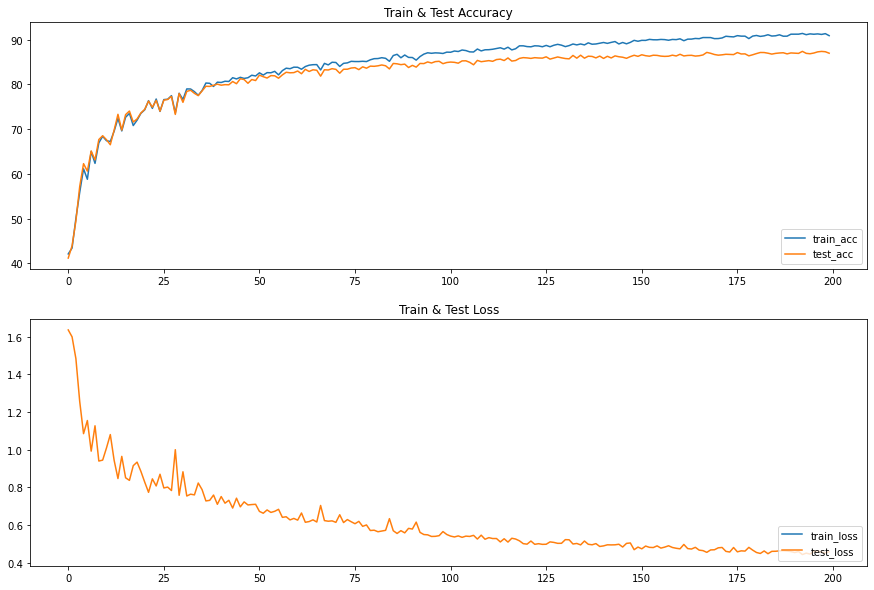

In [16]:
fig, axs = plt.subplots(2, figsize=(15,10))
axs[0].set_title('Train & Test Accuracy')
axs[0].plot(ulb_train_acc,label='train_acc')
axs[0].plot(test_acc,label='test_acc')
axs[0].legend(loc='lower right')

axs[1].set_title('Train & Test Loss')
axs[1].plot(ulb_train_loss,label='train_loss')
axs[1].plot(test_loss,label='test_loss')
axs[1].legend(loc='lower right')

In [17]:
top1_acc = max(test_acc)
best_model_state = test_acc.index(top1_acc)
top1_loss = test_loss[best_model_state]

#get train acc at that state
top1_train_acc = ulb_train_acc[best_model_state]

print("Top-1 Test Acc: ", top1_acc)
print("Loss: ", top1_loss)
print("Corresponding train acc: ", top1_train_acc)
print("Best model state: ", best_model_state)

Top-1 Test Acc:  87.39
Loss:  0.44277459080219267
Corresponding train acc:  91.4
Best model state:  192
